In [ ]:
import torch
import argparse
from utils import *
import matplotlib.pyplot as plt

from models.gat import GATNet
from models.gat_gcn import GAT_GCN
from models.gcn import GCNNet
from models.ginconv import GINConvNet

from models.plm_ginconv import PLM_GINConvNet
from models.plm_gat import PLM_GATNet
from models.plm_gat_gcn import PLM_GAT_GCN
from models.plm_gcn import PLM_GCNNet

from models.esm_gat import ESM_GATNet

import csv
import random
import re

datasets = ['davis', 'kiba', 'davis_mutation']

all_models = {
    'GINConvNet': GINConvNet, 
    'GATNet': GATNet, 
    'GAT_GCN': GAT_GCN, 
    'GCNNet': GCNNet,

    'ESM_GATNet': ESM_GATNet,
    'PLM_GINConvNet': PLM_GINConvNet,
    'PLM_GATNet': PLM_GATNet,
    'PLM_GAT_GCN': PLM_GAT_GCN,
    'PLM_GCNNet': PLM_GCNNet
}

TEST_BATCH_SIZE = 512
NUM_WORKERS = 24

In [3]:
def predicting(model, device, loader):
    model.eval()
    total_preds = []
    total_labels = []
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in tqdm(loader, total=len(loader), leave=False, desc="Predicting"):
        # for data in loader:
            data = data.to(device, non_blocking=True)
            with torch.cuda.amp.autocast():
                output = model(data)
            total_preds.append(output.cpu())
            total_labels.append(data.y.view(-1, 1).cpu())
            
    total_preds = torch.cat(total_preds, dim=0)
    total_labels = torch.cat(total_labels, dim=0)
    return total_labels.numpy().flatten(),total_preds.numpy().flatten()

In [16]:
def plot_histograms(labels, predictions, bin_count = 50, save_dir = None):
    G = labels
    P = predictions
    xmin = min(G.min(), P.min())
    xmax = max(G.max(), P.max())

    # Define specific bin edges based on combined min and max
    bin_edges = np.linspace(np.floor(xmin), np.ceil(xmax), bin_count)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # Histogram for labels
    ax1.hist(G, bins=bin_edges)
    ax1.set_xlabel('Label value - G')
    ax1.set_ylabel('Bin count')
    ax1.grid(True)

    # Histogram for predictions
    ax2.hist(P, bins=bin_edges)
    ax2.set_xlabel('Prediction value - P')
    ax2.set_ylabel('Bin count')
    ax2.grid(True)

    # Set the same axis range for both subplots
    ymin = 0
    ymax = max(ax1.get_ylim()[1], ax2.get_ylim()[1])

    ax1.set_xlim([xmin, xmax])
    ax1.set_ylim([ymin, ymax])
    ax2.set_xlim([xmin, xmax])
    ax2.set_ylim([ymin, ymax])

    # Title for the entire figure
    fig.suptitle('Histogram of predictions and labels')
    
    if save_dir is not None:
        plt.savefig(save_dir)
    plt.show()

In [17]:
def plot_scatter(labels, predictions, save_dir = None):
    G = labels
    P = predictions

    plt.figure(figsize=(8, 8))
    plt.scatter(G, P, alpha=0.5)
    plt.xlabel('Label value - G')
    plt.ylabel('Prediction value - P')
    plt.title('Scatter plot of predictions vs labels')
    plt.grid(True)

    # Equal limits
    min_val = min(G.min(), P.min())
    max_val = max(G.max(), P.max())
    plt.xlim(min_val, max_val)
    plt.ylim(min_val, max_val)

    # y=x line
    plt.plot([min_val, max_val], [min_val, max_val], 'r--')
    
    if save_dir is not None:
        plt.savefig(save_dir)
    plt.show()

In [ ]:
dataset = 'davis_mutation'
model = 'GINConvNet'

plm_layers = None
conv_layers = [32, 64, 96]
kernel_size = 32

description = None
protein_embedding_type = None
fold_setting = 'setting1'

cuda = 0
cuda_name = f"cuda:{cuda}"
seed = 42

In [11]:
modeling = all_models[model]
model_st = modeling.__name__

# Set seed:
if seed is not None:
    os.environ["CUBLAS_WORKSPACE_CONFIG"]=":4096:8"
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms(True)

In [13]:
# group_name = f"{model}_{dataset}_plm_{plm_layers}_conv_{conv_layers}_kernel_{kernel_size}"
run_name = f"{model}_{dataset}_plm_{plm_layers}_conv_{conv_layers}_kernel_{kernel_size}"
if description is not None:
    run_name += f"_desc_{description}"
    # group_name += f"_desc_{description}"
if fold_setting is not None and fold_setting != "setting1":
    run_name += f"_fold_{fold_setting}"
    # fold_group_name = re.sub(r"_\d+$", "", fold_setting)
    # group_name += f"_fold_{fold_group_name}"
# if seed is not None:
#     run_name += f"_seed_{seed}"

if protein_embedding_type is not None:
    protein_emb_path = f"data/{dataset}/proteins_{protein_embedding_type}.json"
    with open(protein_emb_path, "r") as f:
        protein_emb_data = json.load(f)
    first_emb = protein_emb_data[0]["embedding"]
    embed_dim = len(first_emb)
else:
    embed_dim = 128  # default embedding dimension if no precomputed embeddings are used

In [15]:
print('\nrunning on ', model_st + '_' + dataset )
dta_dataset = DTADataset(root='data', dataset=dataset, protein_embedding_type=protein_embedding_type, fold_setting=fold_setting)
test_dataset = dta_dataset[dta_dataset._data.fold == -1]
test_loader = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False, pin_memory = True, num_workers = NUM_WORKERS//2)

device = torch.device(cuda_name if torch.cuda.is_available() else "cpu")

model = modeling(embed_dim = embed_dim, plm_layers = plm_layers, conv_layers = conv_layers, kernel_size = kernel_size).to(device)

all_predictions = []
for train_seed in range(0, 5):
    model_file_name = 'trained_models/model_' + run_name + '_seed_' + str(train_seed) + '_testing.pt'
    model.load_state_dict(torch.load(model_file_name))
    print(f'Model loaded from {model_file_name}.')
    G, P = predicting(model, device, test_loader)
    all_predictions.append(P)

P = np.mean(all_predictions, axis=0)
print(P)


running on  GINConvNet_davis_mutation
Pre-processed data found: data/processed/davis_mutation_setting1.pt, loading ...
GINConvNet(
  (dropout): Dropout(p=0.2, inplace=False)
  (relu): ReLU()
  (conv1): GINConv(nn=Sequential(
    (0): Linear(in_features=78, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): GINConv(nn=Sequential(
    (0): Linear(in_features=32, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
  ))
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): GINCo

Model loaded from trained_models/model_GINConvNet_davis_mutation_plm_None_conv_[32, 64, 96]_kernel_32_seed_1_testing.pt.
Make prediction for 5010 samples...


Model loaded from trained_models/model_GINConvNet_davis_mutation_plm_None_conv_[32, 64, 96]_kernel_32_seed_2_testing.pt.
Make prediction for 5010 samples...


Model loaded from trained_models/model_GINConvNet_davis_mutation_plm_None_conv_[32, 64, 96]_kernel_32_seed_3_testing.pt.
Make prediction for 5010 samples...


Model loaded from trained_models/model_GINConvNet_davis_mutation_plm_None_conv_[32, 64, 96]_kernel_32_seed_4_testing.pt.
Make prediction for 5010 samples...


[5.    4.992 5.055 ... 4.992 5.074 5.246]


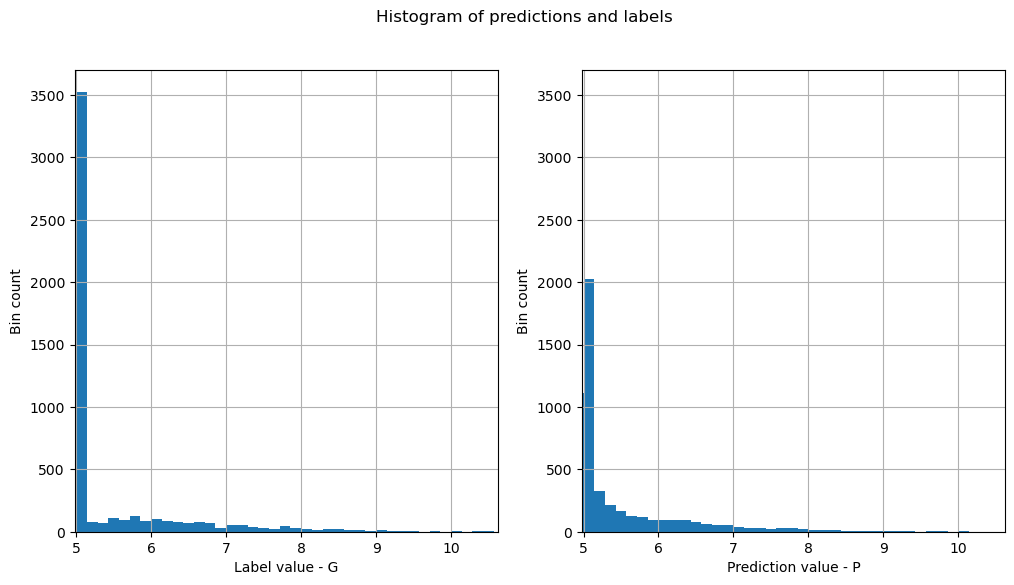

In [ ]:
# histogram_dir = 'images/histograms'
# os.makedirs(histogram_dir, exist_ok=True)
plot_histograms(G, P)

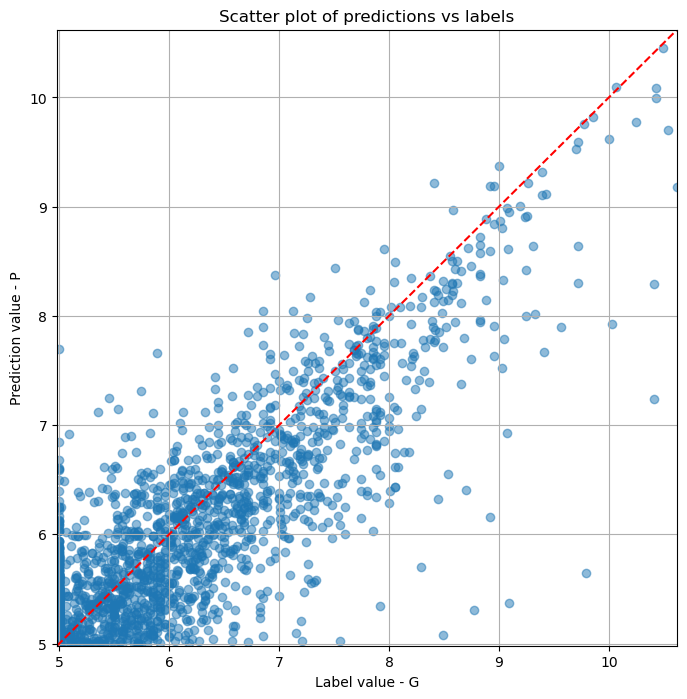

In [ ]:
# scatter_dir = 'images/scatter_plots'
# os.makedirs(scatter_dir, exist_ok=True)
plot_scatter(G, P)

In [ ]:
# Save test predictions       
# output_dir = 'analysis/predictions'
# os.makedirs(output_dir, exist_ok=True)
# output_data_file = os.path.join(output_dir, run_name + '_test_predictions.csv')

# with open(test_data_file, 'r') as infile, open(output_data_file, 'w', newline='') as outfile:
#     reader = csv.reader(infile)
#     writer = csv.writer(outfile)
    
#     # Read the header and add the new column name
#     header = next(reader)
#     header.append('prediction')
#     writer.writerow(header)
    
#     # Iterate over the rows and append the predictions
#     for i, row in enumerate(reader):
#         row.append(P[i])
#         writer.writerow(row)
# print("Predictions written to .csv file successfully.")